In [97]:
import numpy as np
import pandas as pd
import scipy.optimize as sci_optim
import matplotlib.pyplot as plt

In [98]:
# Load data
data = np.genfromtxt('xbtusd.csv', delimiter=',')
Y = data[1:,-1] # get de-trended BITCOIN prices. Also, remove first value, since it is NaN.

# Forecast

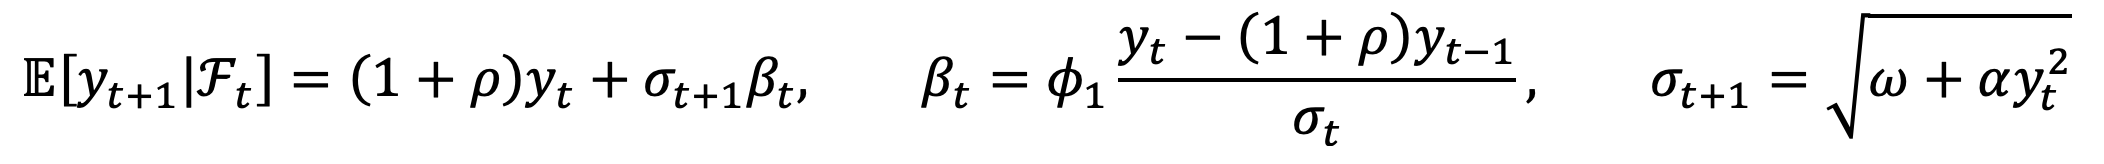

In [7]:
def DARMA_forecast(parameters, data):
    
    rho, omega, alpha, phi = parameters

    t = -1 # define start index 

    y = lambda t: (data[t])
    sigma = lambda t: np.sqrt(omega + alpha * (y(t-1) ** 2))
    beta = lambda t: phi * ( y(t) - (1 + rho) * y(t-1) ) / sigma(t)

    y_pred = (1+rho) * y(t) + sigma(t+1) * beta(t)

    return y_pred

In [11]:
DARMA_forecast(rho_est, omega_est, alpha_est, phi_est, Y[0:3]),Y[0]

(13.99868791490411, array([27.98987445, 22.70122262, 17.95695986]))

In [8]:
def generate_darma_forecasts(rho, omega, alpha, phi, Y):
    start = 0
    t = 2
    y_pred_array = [] 

    n_forecasts = len(Y) - t + 1

    # Add NaN values for the first t = 2 elements
    y_pred_array.extend(np.nan for i in range(1, t + 1))

    # Loop to generate 1-step-ahead forecasts
    for _ in range(t, t + n_forecasts):
        y_pred_t = DARMA_forecast(rho, omega, alpha, phi, Y[start:t])
        y_pred_array.append(y_pred_t)

        # Increment the window for the next forecast
        start += 1
        t += 1

    # Convert to a NumPy array
    #y_pred_array = np.array(y_pred_array)

    y_pred_array = np.array(y_pred_array)

    return y_pred_array

DARMA_forecast_array = generate_darma_forecasts(rho_est, omega_est, alpha_est, phi_est, Y)

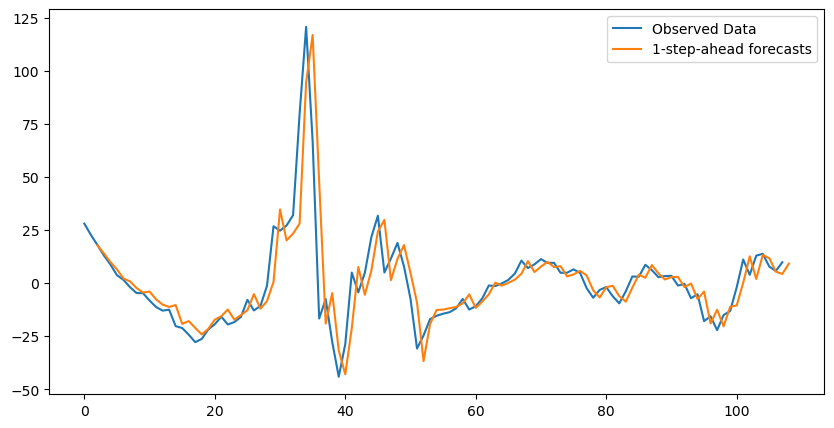

In [9]:
plt.figure(figsize=(10, 5))  # Set the figure size
plt.plot(Y, label='Observed Data')
plt.plot(DARMA_forecast_array, label='1-step-ahead forecasts')
plt.legend()

In [220]:
# Load data
data = np.genfromtxt('xbtusd.csv', delimiter=',')
Y = data[1:,-1] # get de-trended BITCOIN prices. Also, remove first value, since it is NaN.

# Simulate DAR

In [392]:
def DAR_sim(parameters, T, set_seed):
    np.random.seed(set_seed)
    rho, omega, alpha = parameters

    max_lag = 1
    
    # Initialize arrays
    Y = np.zeros(T)
    Z = np.random.normal(loc=0, scale=1, size=T)

    # Initialize the process
    Y[0] = 1 

    # Define function objects at time t
    y = lambda t: Y[t]
    z = lambda t: Z[t]
    sigma = lambda t: np.sqrt(omega + alpha * Y[t-1]**2)
    epsilon = lambda t: sigma(t) * z(t)

    # The model
    DAR = lambda t: rho * y(t-1) + epsilon(t)

    # Update Y
    for t in range(max_lag, T):
        Y[t] = DAR(t)
    return Y

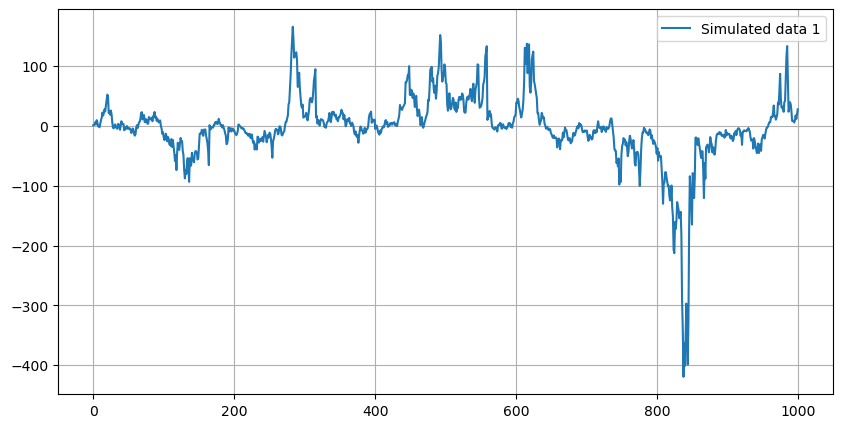

In [393]:
rho_sim = 1
omega_sim = 20
alpha_sim = 0.1
T_sim = 1000

parameters_sim = rho_sim, omega_sim, alpha_sim
DAR_simulated = DAR_sim(parameters_sim, T = T_sim, set_seed = 422413)

plt.figure(figsize=(10, 5))  # Set the figure size
plt.plot(DAR_simulated, label='Simulated data 1')
plt.grid()
plt.legend()

# Simulate DARMA

In [373]:
def DARMA_sim(parameters, T, set_seed):
    np.random.seed(set_seed)
    rho, omega, alpha, phi = parameters

    max_lag = 2
    
    # Initialize arrays
    Y = np.zeros(T)
    ETA = np.random.normal(loc=0, scale=1, size = T)

    # Initialize the process
    Y[0] = 1 

    # Define function objects at time t
    y = lambda t: Y[t]
    eta = lambda t: ETA[t]
    sigma = lambda t: np.sqrt(omega + alpha * y(t-1)**2)
    beta = lambda t: phi * (y(t) - rho * y(t-1)) / sigma(t)
    
    # The model
    DARMA = lambda t: rho * y(t-1) + sigma(t) * beta(t-1) + sigma(t) * eta(t)

    # Recursively comput the model
    for t in range(max_lag, T):
        Y[t] = DARMA(t)
    return Y

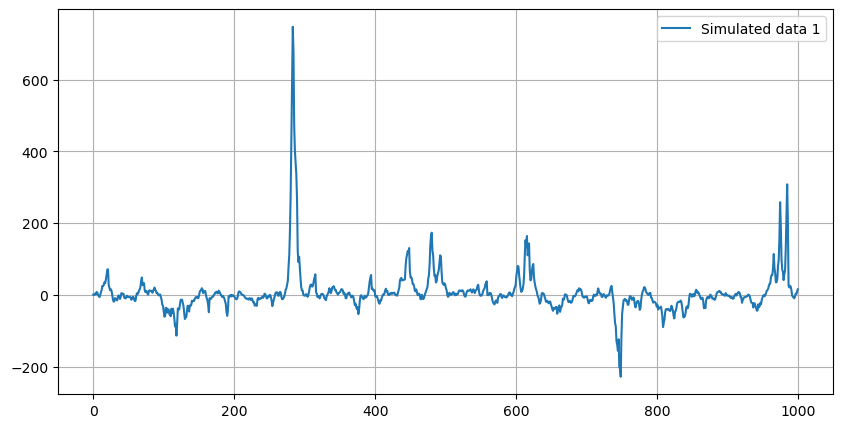

In [389]:
rho_sim = 0.9
omega_sim = 20
alpha_sim = 0.1
phi_sim = 0.4
T_sim = 1000

parameters_sim = rho_sim, omega_sim, alpha_sim, phi_sim
DARMA_simulated = DARMA_sim(parameters_sim, T = T_sim, set_seed = 422413)

plt.figure(figsize=(10, 5))  # Set the figure size
plt.plot(DARMA_simulated, label='Simulated data 1')
plt.grid()
plt.legend()

# Estimate DAR

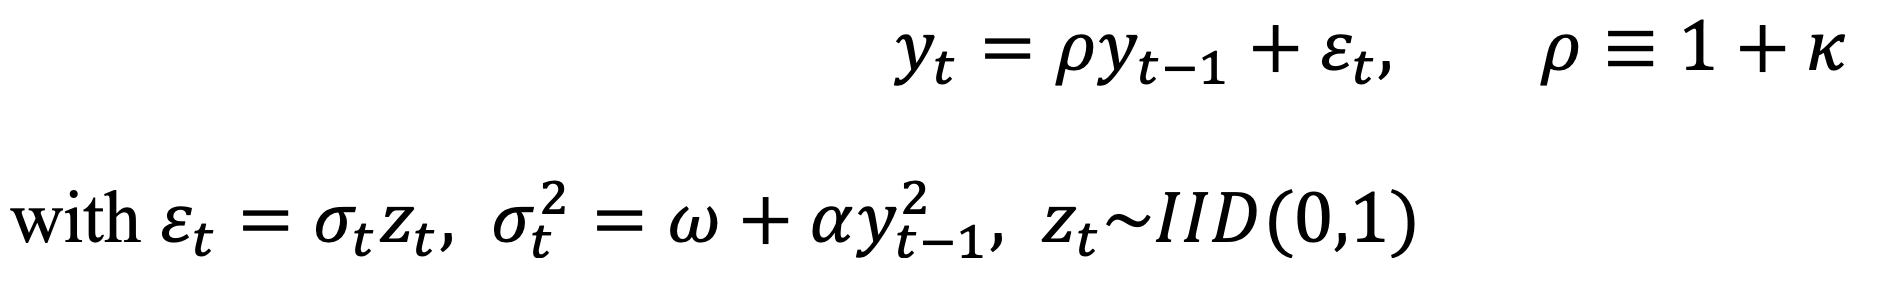

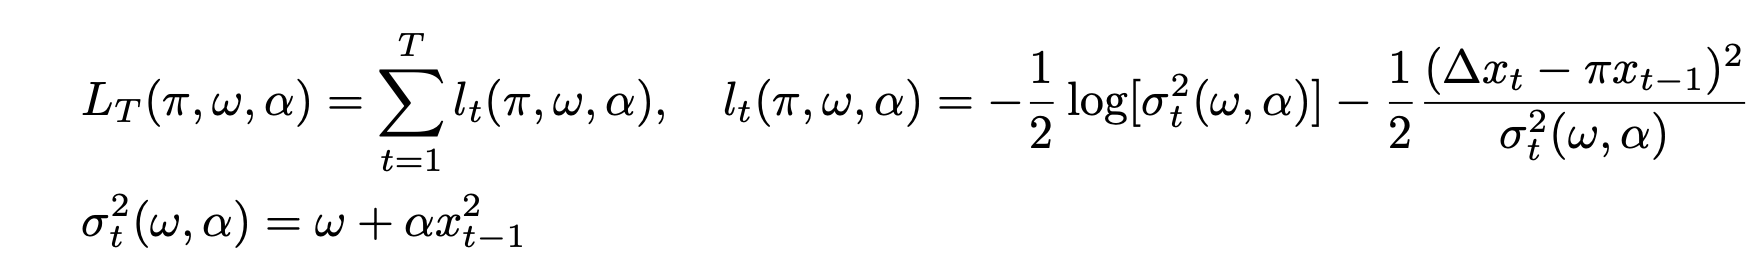

In [217]:
def MLE_DAR(Y):
    def loglikelihood_function(params):

        rho, omega, alpha = params
        
        # define time t
        T = len(Y)
        max_lag = 1 # maximum lag in the model
        start_index = -1 # set -1 since the latest time series observation is the last value in Y
        stop_index = -(T-(max_lag - 1))
        t = np.arange(start = start_index, stop = stop_index, step = -1)
        
        # define functions at time t
        y = lambda t: (Y[t])
        sigma = lambda t: np.sqrt(omega + alpha * (y(t-1) ** 2))
        cond_mean = lambda t: rho * y(t-1)
        
        # compute sum of likelihood contributions
        first_term = -1/2 * np.log(sigma(t)**2)
        second_term = -1/2 * (y(t) - cond_mean(t))**2 / sigma(t)**2
        L_t = np.sum(first_term + second_term)
        
        return -L_t
    
    # initialise parameters
    rho_init = 0.0
    omega_init = 0.05
    alpha_init = 0.5
    init_params = np.array([rho_init, omega_init, alpha_init])

    # set parameter bounds
    rho_bound = (0,None)
    omega_bound = (0,None)
    alpha_bound = (0,None)
    bounds_params = (rho_bound, omega_bound, alpha_bound)

    MLE_estimates = sci_optim.minimize(loglikelihood_function, init_params, method='SLSQP', bounds = bounds_params)

    return MLE_estimates.x

# Estimate DARMA

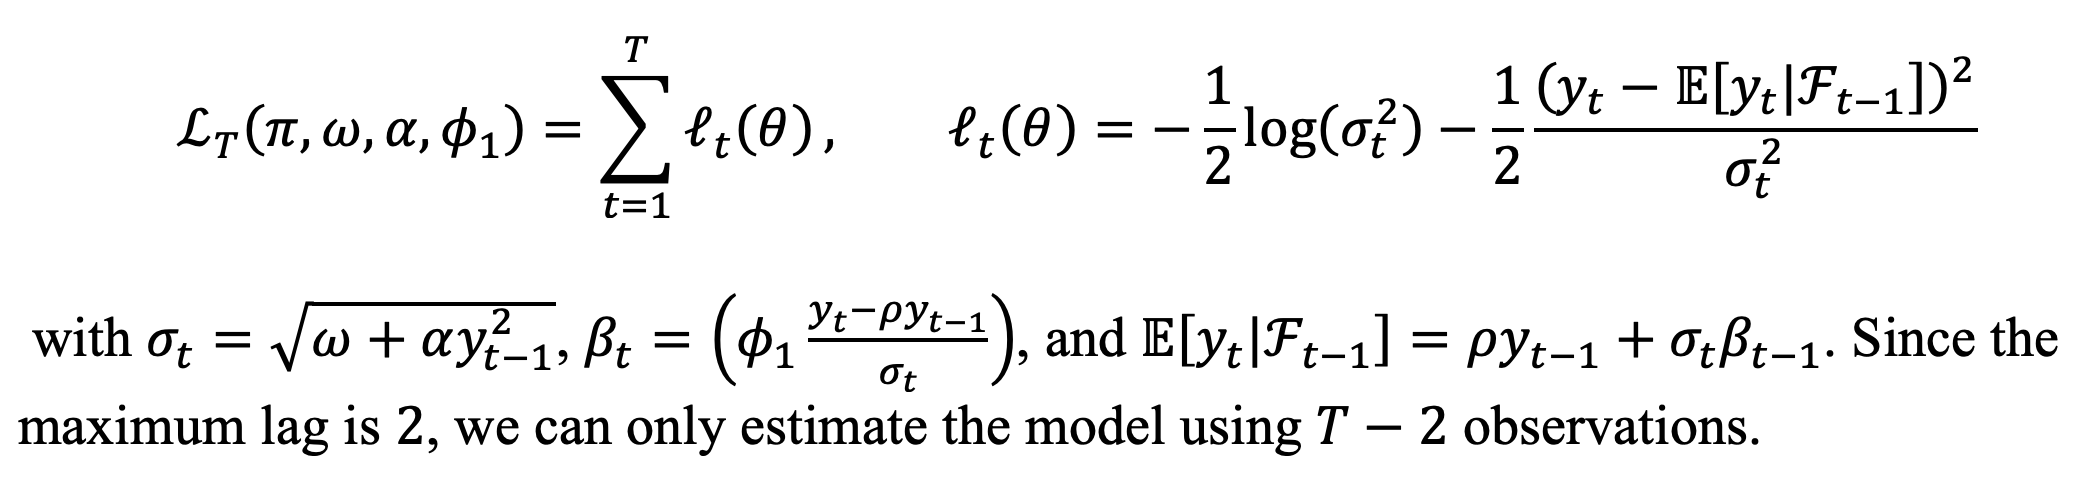

In [226]:
def MLE_DARMA(Y):
    def loglikelihood_function(params):

        rho, omega, alpha, phi = params
        
        # define time t
        max_lag = 2 # maximum lag in the model
        start_index = -1 # set -1 since the latest time series observation is the last value in Y
        stop_index = -(len(Y)-(max_lag - 1))
        t = np.arange(start = start_index, stop = stop_index, step = -1)
        
        # define functions at time t
        y = lambda t: (Y[t])
        sigma = lambda t: np.sqrt(omega + alpha * y(t-1)**2)
        beta = lambda t: phi * (y(t) - rho * y(t-1)) / sigma(t)
        
        cond_mean = lambda t: rho * y(t-1) + sigma(t) * beta(t-1)
        
        # compute sum of likelihood contributions
        first_term = -1/2 * np.log(sigma(t)**2)
        second_term = -1/2 * (y(t) - cond_mean(t))**2 / sigma(t)**2
        L_t = np.sum(first_term + second_term)
        
        return -L_t
    
    # initialise parameters
    rho_init = 0.0
    omega_init = 0.05
    alpha_init = 0.5
    phi_init = 0.0
    init_params = np.array([rho_init, omega_init, alpha_init, phi_init])

    # set parameter bounds
    rho_bound = (0,None)
    omega_bound = (0,None)
    alpha_bound = (0,None)
    phi_bound = (None,None)
    bounds_params = (rho_bound, omega_bound, alpha_bound,phi_bound)

    MLE_estimates = sci_optim.minimize(loglikelihood_function, init_params, method='SLSQP', bounds = bounds_params)

    return MLE_estimates.x

In [227]:
MLE_DARMA(Y)

array([ 0.77501016, 46.88320846,  0.17377209,  0.26393704])

In [218]:
# parameters_DAR = MLE_DAR(Y_DAR_sim)
#print(f"True parameters: {parameters_sim}")
#print(f"Emil method: {params_method2}")


True parameters: (1, 20, 0.1)
Rahbek method: [ 1.00118896 19.76305294  0.10119634]
Emil method: [ 1.00118871 19.76301767  0.10119679]
